In [1]:
import os
import tweepy as tw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def twitter_connection():
    consumer_api_key = "cWQovPtPiMiO15bQbmgxdk92T"
    consumer_api_secret = "5KApQ5UnUIzjfi2bs1WmXwgvoR1aXhhYngYUJqsY4KLkk7dtRZ"

    auth = tw.OAuthHandler(consumer_api_key, consumer_api_secret)
    api = tw.API(auth, wait_on_rate_limit=True)
    return api


In [3]:
def create_cursor(api, search_words, date_since, language="en", items_limit=10000):
    
    # Collect tweets
    tweets = tw.Cursor(api.search,
                  q=search_words,
                  lang=language,
                  since=date_since).items(items_limit)


    print(f"retreive new tweets ...")
    tweets_copy = []
    for tweet in tqdm(tweets):
        tweets_copy.append(tweet)
     
    print(f"new tweets retrieved: {len(tweets_copy)}")

    return tweets_copy

In [4]:
def build_dataset(tweets_copy):
    tweets_df = pd.DataFrame()
    for tweet in tqdm(tweets_copy):
        hashtags = []
        try:
            for hashtag in tweet.entities["hashtags"]:
                hashtags.append(hashtag["text"])
        except:
            pass
        tweets_df = tweets_df.append(pd.DataFrame({'id': tweet.id,
                                                   'user_name': tweet.user.name, 
                                                   'user_location': tweet.user.location,\
                                                   'user_description': tweet.user.description,
                                                   'user_created': tweet.user.created_at,
                                                   'user_followers': tweet.user.followers_count,
                                                   'user_friends': tweet.user.friends_count,
                                                   'user_favourites': tweet.user.favourites_count,
                                                   'user_verified': tweet.user.verified,
                                                   'date': tweet.created_at,
                                                   'text': tweet.text, 
                                                   'hashtags': [hashtags if hashtags else None],
                                                   'source': tweet.source,
                                                   'retweets': tweet.retweet_count,
                                                   'favorites': tweet.favorite_count,
                                                   'is_retweet': tweet.retweeted}, index=[0]))
    return tweets_df

In [5]:
def update_and_save_dataset(tweets_df):   
    file_path = "tokyo_2020_tweets.csv"
    if os.path.exists(file_path):
        tweets_old_df = pd.read_csv(file_path)
        print(f"past tweets: {tweets_old_df.shape}")
        tweets_all_df = pd.concat([tweets_old_df, tweets_df], axis=0)
        print(f"new tweets: {tweets_df.shape[0]} past tweets: {tweets_old_df.shape[0]} all tweets: {tweets_all_df.shape[0]}")
        tweets_new_df = tweets_all_df.drop_duplicates(subset = ["id"], keep='last', inplace=False)
        print(f"all tweets: {tweets_new_df.shape}")
        tweets_new_df.to_csv(file_path, index=False)
    else:
        print(f"tweets: {tweets_df.shape}")
        tweets_df.to_csv(file_path, index=False)

##APPLY API


In [8]:
api = twitter_connection()
tweets_copy = create_cursor(api=api, search_words="Olympic2021 -filter:retweets",
                                date_since="2020-07-22",language="en",
                                items_limit=15000)

retreive new tweets ...


1it [00:00,  4.94it/s]

new tweets retrieved: 1


In [9]:
tweets_df = build_dataset(tweets_copy)
update_and_save_dataset(tweets_df)
tweets_df

100%|██████████| 1/1 [00:00<00:00, 54.56it/s]

tweets: (1, 16)


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1465572788832387075,Poornima University,Jaipur,Building a community of wide ranging interests...,2012-03-17 06:36:29,1849,79,356,False,2021-11-30 06:45:56,We would like to inform you that Dr. Suresh Pa...,None,Twitter for iPhone,0,2,False


In [10]:
df = tweets_df
#drop duplicates 去重
data=df.drop_duplicates(subset=['id'],keep='first',inplace=False)
data=df.drop_duplicates(subset=['text'],keep='first',inplace=False)
#only original tweets 筛选is retweet是false的原创微博
data = data[data['is_retweet']==False] #159470 rows × 16 columns

# drop na 去空
data = data[['id','user_name','user_followers','user_verified','date','text','retweets','favorites','is_retweet']]
data = data.dropna()

In [11]:
data = data[data['favorites']>0]
data = data[['id','user_name','user_followers','user_verified','date','text','retweets','favorites','is_retweet']]
len(data)

1

最大的点赞量： 2
favorites num is 0: 0


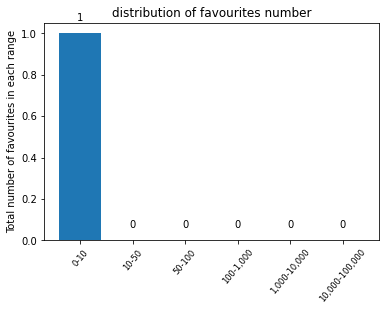

In [12]:
# distribution of favourites
likesnum = data['favorites'].astype(int)#转化成整数，原来的数据有float有string比较杂乱
likesnum = np.array(likesnum)
print("最大的点赞量：",likesnum.max())
print("favorites num is 0:",sum(likesnum==0))
like_0_10 = ((0 <= likesnum) & (likesnum < 10)).sum()#0-10
like_10_50 =((10 <= likesnum) & (likesnum < 50)).sum() #10-50
like_50_100 = ((50 <= likesnum) & (likesnum < 100)).sum()#50-100 41424
like_100_1000 = ((100 <= likesnum) & (likesnum < 1000)).sum()#100-1000 16967
like_1000_1w = ((1000 <= likesnum) & (likesnum < 10000)).sum()#1000-1w 7673
like_1w_10w = ((10000 <= likesnum) & (likesnum < 100000)).sum()#1000-1w 7673


x = range(6)
y = np.array([like_0_10, like_10_50, like_50_100, like_100_1000, like_1000_1w, like_1w_10w])

x_label = ["0-10","10-50","50-100","100-1,000","1,000-10,000","10,000-100,000"]
plt.xticks(x,x_label,size="small",rotation=50)


plt.ylabel("Total number of favourites in each range")
for a,b in zip(x,y):
  plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.title("distribution of favourites number")
plt.bar(x,y)
plt.show()

In [ ]:
# t = data.to_csv("data1080")